In [1]:
!pip install biosppy
from biosppy.signals import ecg
import pandas as pd
import os
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 3.4 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Reading The Data

In [2]:
path = '/kaggle/input/ecg-file/045_0-500000_corrected.csv'
df = pd.read_csv(path)
# df.head()

In [3]:
peak = df[df['Label']==1]
not_peak = df[df['Label']==0]

print("Peak : {}".format(len(peak)))
print("Not Peak : {}".format(len(not_peak)))

Peak : 644
Not Peak : 499356


# Evaluating the Sampling Rate

In [4]:
total_data_points = len(df)  # Total number of data points
total_duration = df['Time'].iloc[-1] - df['Time'].iloc[0]  # Total duration in seconds

# Calculate the sampling rate
sampling_rate = total_data_points / total_duration
print("Sampling rate:", sampling_rate, "Hz")

Sampling rate: 4807.692307692308 Hz


# Prediction with Biosppy

In [5]:
raw_array = df['Raw'].to_numpy()
out = ecg.ecg(signal=raw_array, sampling_rate=sampling_rate, show=False)

In [6]:
# R peak locations
rpeak_locations = out['rpeaks']
labels = np.zeros(len(df))
labels[rpeak_locations] = 1 

In [9]:
len(rpeak_locations)

198

In [10]:
#Adding new column to compare the values
data = df.copy()
data['Pred'] = labels

In [11]:
act_r = data['Label']
r_predicted = data['Pred']

In [29]:
act_r[act_r==1].index

Int64Index([   320,   1096,   1887,   2674,   3462,   4247,   5034,   5821,
              6602,   7387,
            ...
            492763, 493534, 494295, 495067, 495860, 496663, 497438, 498202,
            498960, 499770],
           dtype='int64', length=644)

# Evaluating the predicted model
**Sampling rate = Actual data sampling rate**

In [12]:
from sklearn.metrics import classification_report
print(classification_report(act_r, r_predicted))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    499356
         1.0       0.01      0.00      0.00       644

    accuracy                           1.00    500000
   macro avg       0.50      0.50      0.50    500000
weighted avg       1.00      1.00      1.00    500000



In [13]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef
roc_auc = roc_auc_score(act_r, r_predicted)
mcc_score = matthews_corrcoef(act_r, r_predicted)
print("ROC-AUC score", roc_auc)
print("Matthews Correlation Coefficient:", mcc_score)

ROC-AUC score 0.5005791434522945
Matthews Correlation Coefficient: 0.0020880102499806867


In [14]:
out_sig = ecg.ecg(signal=raw_array, sampling_rate=1000, show=False)

In [24]:
rpeak_indices = out_sig['rpeaks']

new_labels = np.zeros(len(df))
new_labels[rpeak_indices] = 1

data['Predicted peak'] = new_labels
pred_r = data['Predicted peak']

In [23]:
len(rpeak_indices)

676

In [22]:
len(new_labels[new_labels ==1])

676

In [25]:
#since the neurokit predicts the correct R peaks at a sampling rate of 1000Hz with small variations in the voltage
# we are defining a threshold to evaluate the model
th = [1,2,3]
for i in range(len(act_r)):
    if pred_r[i] == act_r[i]:
        continue
    else:
        for x in th:
            if (pred_r[i]== act_r[i+x]) or (pred_r[i] == act_r[i-x]):
                pred_r[i] = act_r[i]
            else:
                continue

In [28]:
pred_r[pred_r == 1].index

Int64Index([   320,   1096,   1887,   2674,   3462,   3950,   4247,   5034,
              5821,   6602,
            ...
            494819, 495067, 495860, 496663, 497438, 497960, 498202, 498960,
            499528, 499770],
           dtype='int64', length=763)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(act_r, pred_r))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    499356
         1.0       0.84      1.00      0.92       644

    accuracy                           1.00    500000
   macro avg       0.92      1.00      0.96    500000
weighted avg       1.00      1.00      1.00    500000



In [31]:
from sklearn.metrics import roc_curve, auc
roc_auc = roc_auc_score(act_r, pred_r)
mcc_score = matthews_corrcoef(act_r, pred_r)
print("ROC-AUC score", roc_auc)
print("Matthews Correlation Coefficient:", mcc_score)

ROC-AUC score 0.999880846530331
Matthews Correlation Coefficient: 0.9186052239377351


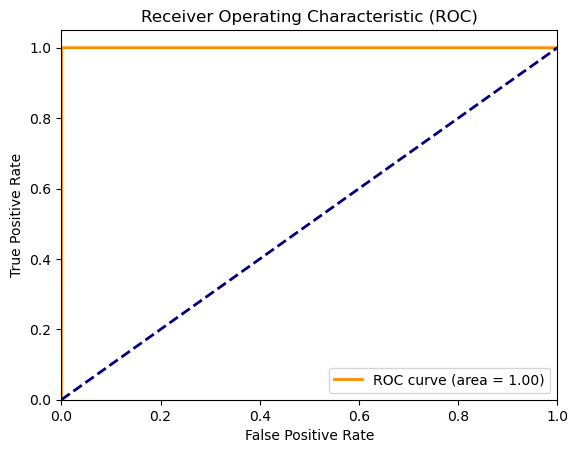

In [32]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(act_r, pred_r)
roc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_curve)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [33]:
data

,Time,Raw,Label,Pred,Predicted peak
0,0.000000,-161.521893,0.0,0.0,0.0
1,0.000208,-178.571427,0.0,0.0,0.0
2,0.000416,-190.236900,0.0,0.0,0.0
3,0.000624,-188.442211,0.0,0.0,0.0
4,0.000832,-189.339555,0.0,0.0,0.0
...,...,...,...,...,...
499995,103.999168,-89.734386,0.0,0.0,0.0
499996,103.999376,-96.015791,0.0,0.0,0.0
499997,103.999584,-112.167981,0.0,0.0,0.0
499998,103.999792,-120.244075,0.0,0.0,0.0


In [36]:
r_peak_times_pred = data[data['Label'] == 1]['Time']
time_intervals_pred = r_peak_times_pred.diff().dropna()
average_time_interval_pred = time_intervals_pred.mean() 
heart_rate_bpm_pred = 60.0 / average_time_interval_pred
print("Actual Heart rate (BPM):", heart_rate_bpm_pred)

Actual Heart rate (BPM): 371.36930278800975


In [35]:
r_peak_times_pred = data[data['Predicted peak'] == 1]['Time']
time_intervals_pred = r_peak_times_pred.diff().dropna()
average_time_interval_pred = time_intervals_pred.mean() 
heart_rate_bpm_pred = 60.0 / average_time_interval_pred
print("Predicted Heart rate (BPM):", heart_rate_bpm_pred)

Predicted Heart rate (BPM): 440.09861387941436
